In [215]:
import numpy as np
import matplotlib 
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable

import fitsio
import glob

from sklearn.decomposition import SparsePCA, FastICA, PCA

import sys
sys.path.append("../")
import pyrosl

from astropy.convolution import convolve, Gaussian2DKernel
from SPyFFI.Cosmics import cosmicImage

%pylab inline --no-import-all
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['figure.figsize']=(16.0,9.0)    #(6.0,4.0)
matplotlib.rcParams['font.size']=16              #10 
matplotlib.rcParams['savefig.dpi']= 150             #72 
colours = mpl.rcParams['axes.prop_cycle'].by_key()['color']


Populating the interactive namespace from numpy and matplotlib


CPU times: user 3.01 s, sys: 11.4 ms, total: 3.02 s
Wall time: 3.02 s


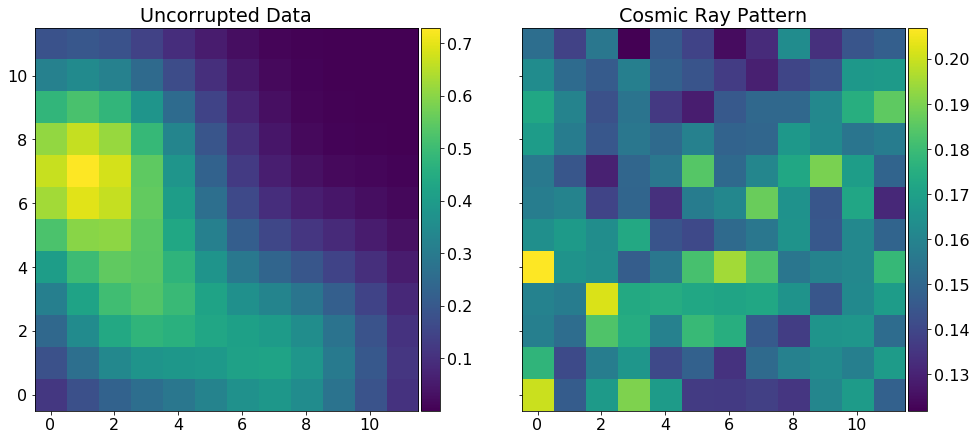

In [375]:
%%time

## use Christina's sample simulation as a benchmark - see https://github.com/christinahedges/ICAntbelievethisworks

# modified from example at 
#http://scikit-learn.org/stable/auto_examples/decomposition/plot_ica_blind_source_separation.html#sphx-glr-auto-examples-decomposition-plot-ica-blind-source-separation-py

from scipy import signal
n_samples = 500
time = np.linspace(0, 8, n_samples)

s1 = np.sin(2 * time)  # Signal 1 : sinusoidal signal
s2 = np.sign(np.sin(3 * time))  # Signal 2 : square signal
s3 = signal.sawtooth(2 * np.pi * time)  # Signal 3: saw tooth signal
nx, ny = 12, 12
dat = np.zeros((500, nx, ny))
dat[:,3,3]=s1
dat[:,7,1]=s2
dat[:,1,7]=s3
for idx, d in enumerate(dat):
    dat[idx] = convolve(d, Gaussian2DKernel(2.5))
# dat += 0.03* np.random.normal(size=dat.shape)
dat /= np.nanmax(dat)
# now add sparse noise in the form of simulated TESS cosmic rays

noise = np.zeros_like(dat)

for j in range(noise.shape[0]):
    cosmic = cosmicImage(size=int(2.**np.ceil(np.log2(max([nx,ny])))),exptime=120.0)
    if np.max(cosmic)>0.:
        cosmic /= np.nanmax(cosmic)
        noise[j,:,:] = cosmic[:nx,:ny]
    
white = 0.000*np.random.randn(*np.shape(noise))
sim = dat+noise+white

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
im1 = ax1.imshow(np.nanstd(dat,axis=0))
ax1.set_title('Uncorrupted Data')

divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)

f.colorbar(im1,cax=cax)

im2 = ax2.imshow(np.nanstd(noise,axis=0))
ax2.set_title('Cosmic Ray Pattern')

divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("right", size="5%", pad=0.05)

f.colorbar(im2,cax=cax2)


In [376]:
X = sim.reshape((n_samples,nx*ny)) # with noise
# X = dat.reshape((n_samples,nx*ny)) # no noise

# X /= X.max()


In [377]:
# Parameters for ROSL
regROSL = 2
estROSL = 10

# Parameters for ROSL+
regROSLp = 0.01
estROSLp = 10
samplesp = (250, 250)


In [378]:
# Run the full version
print ' '
full_rosl = pyrosl.ROSL(
    method = 'full',
    rank = estROSL,
    reg = regROSL,
    verbose = True
   )


In [379]:
%%time
loadings, components, E = full_rosl._fit(X)
loadings = loadings[:, :full_rosl.rank_]
model = np.dot(loadings, full_rosl.components_)
sparse = E.reshape(np.shape(dat))
lowrank = model.reshape(np.shape(dat))

print 'Rank found',full_rosl.rank_


Array must be in Fortran-order. Converting now.
Rank found 10
CPU times: user 87.8 ms, sys: 18.6 ms, total: 106 ms
Wall time: 90.4 ms


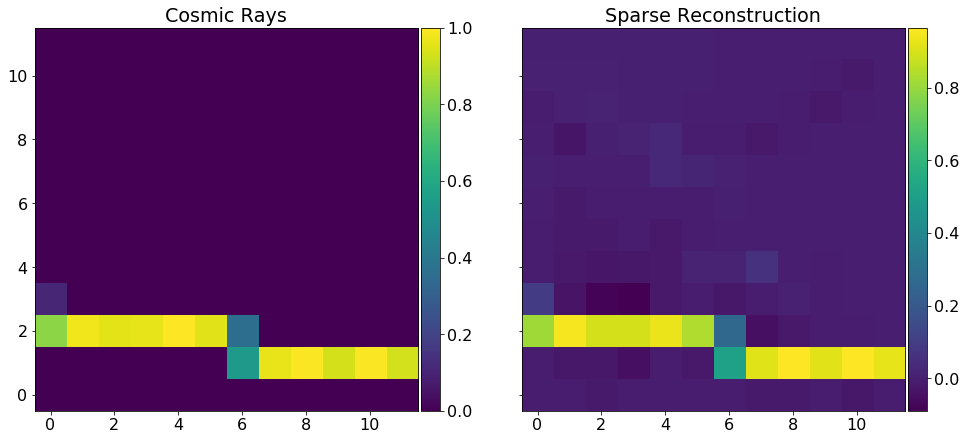

In [380]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
index = 3
im1 = ax1.imshow(noise[index,:,:])
ax1.set_title('Cosmic Rays')
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)

f.colorbar(im1,cax=cax)

im2 = ax2.imshow(sparse[index,:,:])
ax2.set_title('Sparse Reconstruction')
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("right", size="5%", pad=0.05)

f.colorbar(im2,cax=cax2)


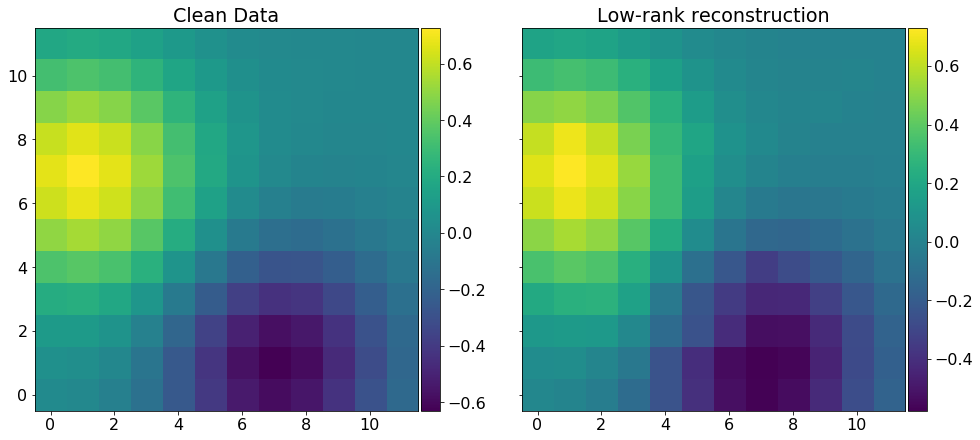

In [381]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
index = 3
im1 = ax1.imshow(dat[index,:,:])
ax1.set_title('Clean Data')

divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)

f.colorbar(im1,cax=cax)

im2 = ax2.imshow(lowrank[index,:,:])
ax2.set_title('Low-rank reconstruction')

divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("right", size="5%", pad=0.05)

f.colorbar(im2,cax=cax2)


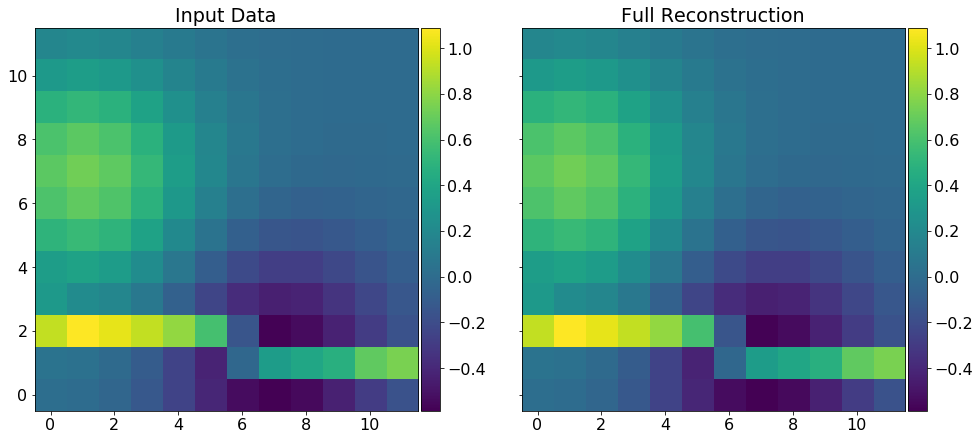

In [382]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
index = 3

im1 = ax1.imshow(sim[index,:,:])
ax1.set_title('Input Data')

divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)

f.colorbar(im1,cax=cax)

im2 = ax2.imshow((sparse+lowrank)[index,:,:])
ax2.set_title('Full Reconstruction')
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("right", size="5%", pad=0.05)

f.colorbar(im2,cax=cax2)


In [383]:
def all_plots(index,f):

    im1 = ax1.imshow(sim[index,:,:])
    ax1.set_title('Input Data')

#     divider = make_axes_locatable(ax1)
#     cax = divider.append_axes("right", size="5%", pad=0.05)

#     f.colorbar(im1,cax=cax)

    im2 = ax2.imshow((sparse)[index,:,:])
    ax2.set_title('Sparse')
#     divider2 = make_axes_locatable(ax2)
#     cax2 = divider2.append_axes("right", size="5%", pad=0.05)

#     f.colorbar(im2,cax=cax2)

    im3 = ax3.imshow((dat)[index,:,:])
    ax3.set_title('Ideal')

#     divider3 = make_axes_locatable(ax3)
#     cax3 = divider3.append_axes("right", size="5%", pad=0.05)

#     f.colorbar(im3,cax=cax3)

    im4 = ax4.imshow((lowrank)[index,:,:])
    ax4.set_title('Low Rank')



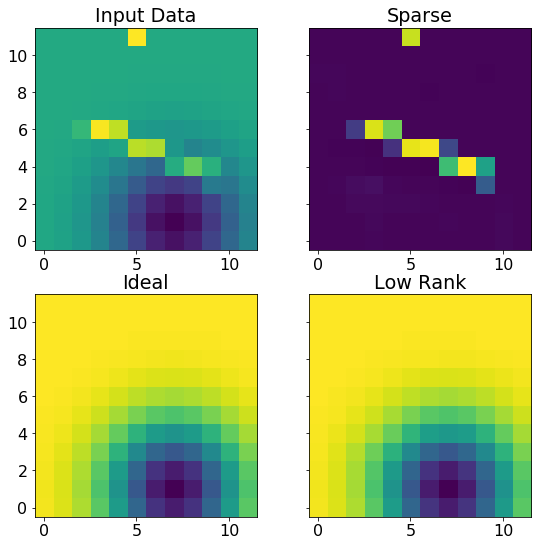

In [384]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharey=True,figsize=(9.0,9.0))

all_plots(0,f)

In [385]:
import matplotlib.animation as manimation

FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title='Movie Test', artist='Matplotlib',
                comment='Movie support!')
writer = FFMpegWriter(fps=15, metadata=metadata)


In [386]:
# %%time 
# plt.rcParams["animation.html"] = "jshtml"
# f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharey=True,figsize=(9.0,9.0))

# with writer.saving(f, "test_video.mp4", 100):

#     for i in range(100):
#         if i % 10 == 0:
#             print i 
#         all_plots(i,f)
#         writer.grab_frame()
# print 'Saved to test_video.mp4'

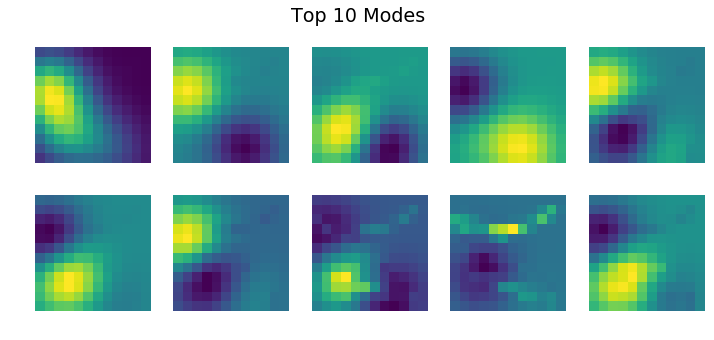

In [387]:
f, axes = plt.subplots(2,5,figsize=(12.0,5.0))
f.suptitle('Top 10 Modes')
for j in range(10):
    axes.ravel()[j].imshow(full_rosl.components_[j,:].reshape((12,12)),interpolation='None')
    axes.ravel()[j].axis('off')
plt.savefig('pca_modes.png',bbox_inches='tight')

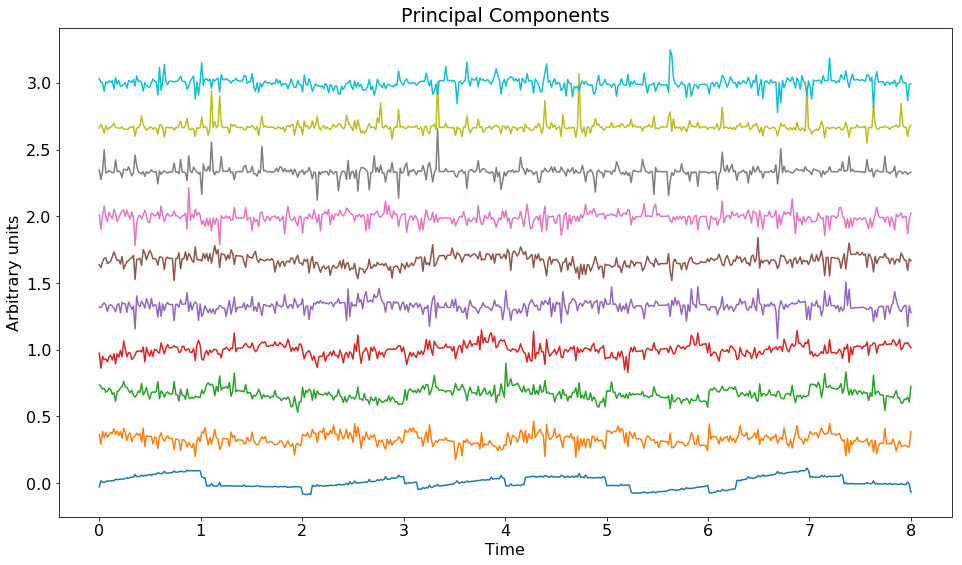

In [388]:
for j in range(10):
    plt.plot(time,loadings[:,j]+j/3.)
    
plt.title('Principal Components')
plt.xlabel('Time')
plt.ylabel('Arbitrary units')
plt.savefig('loadings.png',bbox_inches='tight')

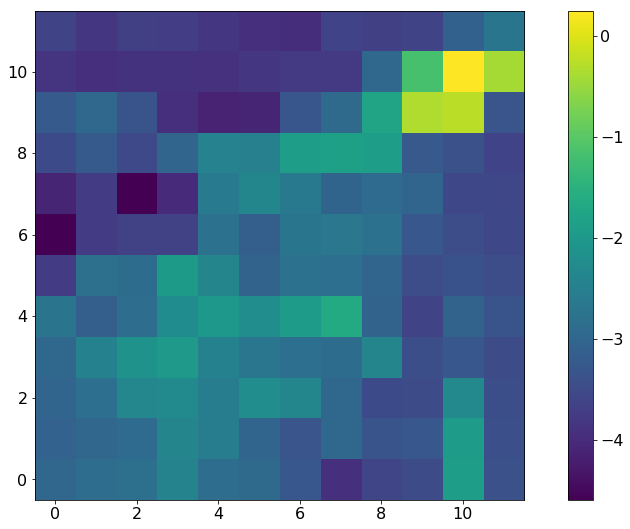

In [389]:
ad = np.abs((lowrank-dat)/dat)
mad = np.nanmedian(ad,axis=0)
plt.imshow(np.log10(mad))
plt.colorbar()

## How does common or garden variety PCA do?

In [390]:
from sklearn.decomposition import SparsePCA, PCA

In [391]:
pca = PCA(n_components=10)

In [392]:
pca_components = pca.fit_transform(X)
transform = pca.inverse_transform(pca_components).reshape((n_samples,nx,ny))

Text(0,0.5,'Arbitrary units')

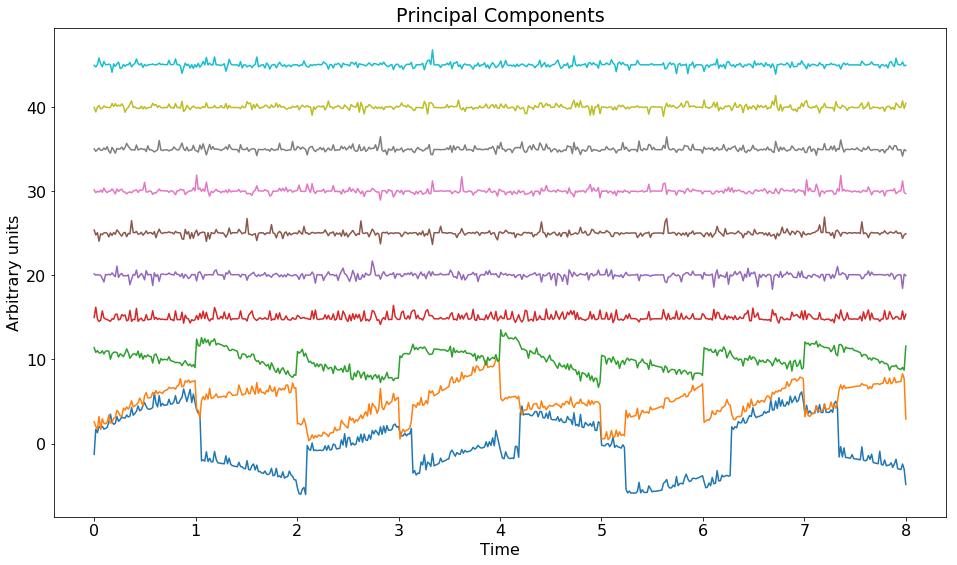

In [393]:
for j in range(10):
    plt.plot(time,pca_components[:,j]+5*j)
    
plt.title('Principal Components')
plt.xlabel('Time')
plt.ylabel('Arbitrary units')
# plt.savefig('loadings.png',bbox_inches='tight')

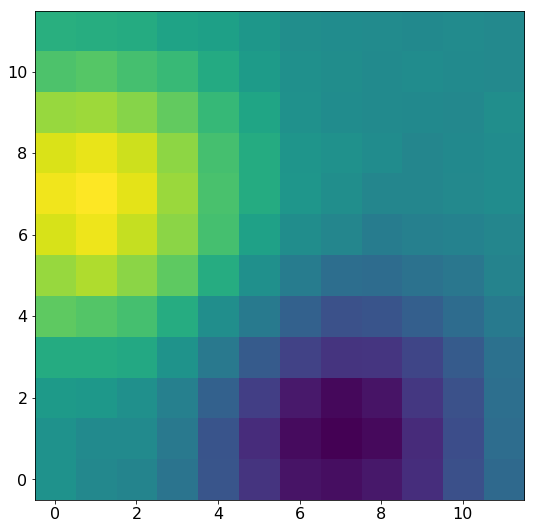

In [394]:
plt.imshow(transform[2,:,:])

In [395]:
def pca_plots(index,f):

    im1 = ax1.imshow(sim[index,:,:])
    ax1.set_title('Input Data')

#     divider = make_axes_locatable(ax1)
#     cax = divider.append_axes("right", size="5%", pad=0.05)

#     f.colorbar(im1,cax=cax)

    im2 = ax2.imshow(transform[index,:,:])
    ax2.set_title('PCA')
#     divider2 = make_axes_locatable(ax2)
#     cax2 = divider2.append_axes("right", size="5%", pad=0.05)

#     f.colorbar(im2,cax=cax2)

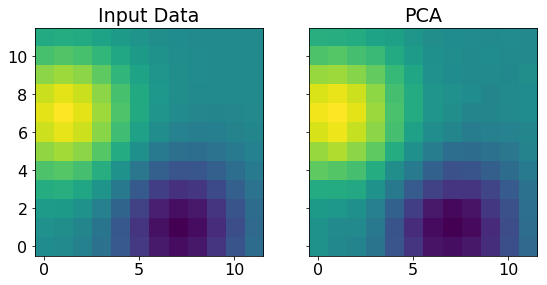

In [396]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(9.0,9.0))

pca_plots(2,f)

In [397]:
# %%time 
# plt.rcParams["animation.html"] = "jshtml"
# f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(9.0,9.0))

# with writer.saving(f, "pca_video.mp4", 100):

#     for i in range(100):
#         if i % 10 == 0:
#             print i 
#         pca_plots(i,f)
#         writer.grab_frame()
# print 'Saved to pca_video.mp4'

In [398]:
ica = FastICA(n_components=3)
S_ = ica.fit_transform(X)  # Reconstruct signals
A_ = ica.mixing_  # Get estimated mixing matrix

S_rpca = ica.fit_transform(model)  # Reconstruct signals
A_rpca = ica.mixing_  # Get estimated mixing matrix
S_rpca = -S_rpca[:,(0,2,1)]


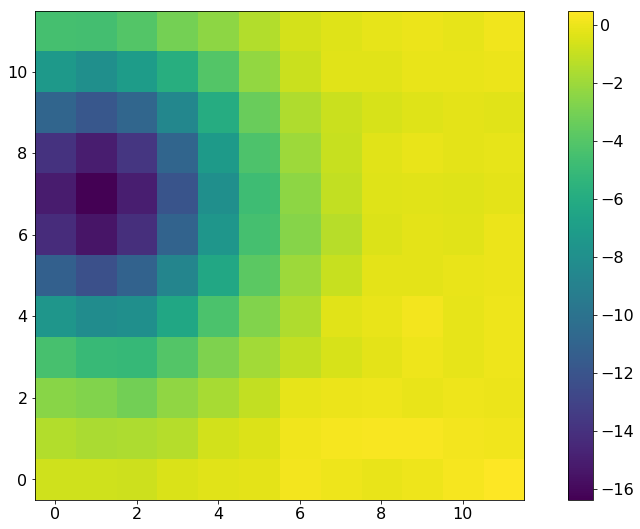

In [399]:
dummy = np.ones((sim.shape[1],sim.shape[2]))
m = np.isfinite(sim[0,:,:])

dummy[~m] = np.nan
dummy[m] = A_[:,2]
plt.imshow(dummy, vmin=np.nanmin(dummy), vmax=np.nanmax(dummy), origin='bottom')
plt.colorbar()

Text(0.5,1,'ICA is Better with RPCA')

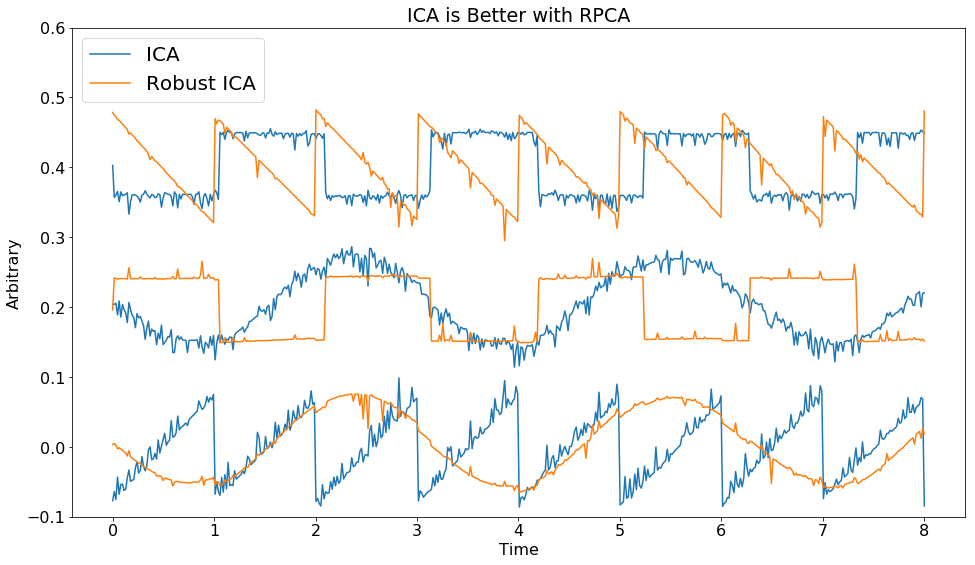

In [400]:
for j in range(3):
    if j == 0:
        plt.plot(time,S_[:,j]+0.2*j,color=colours[0],label='ICA')
        plt.plot(time,S_rpca[:,j]+0.2*j,color=colours[1],label='Robust ICA')
    else:
        plt.plot(time,S_[:,j]+0.2*j,color=colours[0])
        plt.plot(time,S_rpca[:,j]+0.2*j,color=colours[1])

plt.ylim(-0.1,0.6)
        
plt.legend(loc=2,fontsize=20)
plt.xlabel('Time')
plt.ylabel('Arbitrary')
plt.title('ICA is Better with RPCA')

(-3.354030698454745e-07, 3.355097197307989e-07)

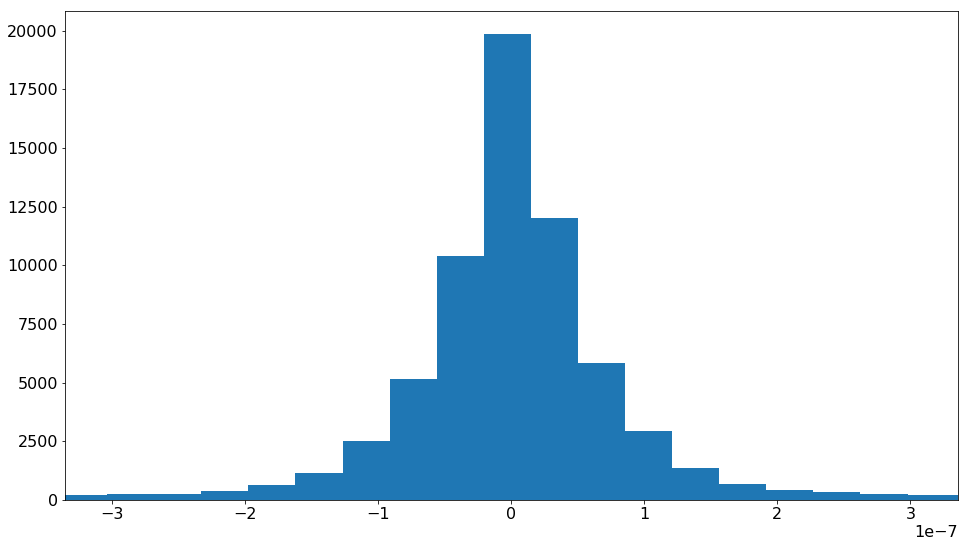

In [401]:
residuals = (model + E - X).ravel()
plt.hist(residuals,bins=250);
plt.xlim(np.percentile(residuals,5),np.percentile(residuals,95))

## How sensitive is RPCA to Gaussian noise?

In [424]:
%%time
errors = 10.**(np.arange(-7,2))
res = []
for error in errors:
    Xn = X + error*np.random.randn(*np.shape(X))

    loadingsn, componentsn, En = full_rosl._fit(Xn)
    loadingsn = loadingsn[:, :full_rosl.rank_]
    modeln = np.dot(loadings, full_rosl.components_)

    residuals = (modeln + En - Xn).ravel()
    mad = np.nanmedian(np.abs(residuals))
    res.append(np.log10(mad))
    print error, np.log10(mad)

Array must be in Fortran-order. Converting now.
1e-07 -0.976773092740096
Array must be in Fortran-order. Converting now.
1e-06 -0.848823830881774
Array must be in Fortran-order. Converting now.
1e-05 -1.2469652876890873
Array must be in Fortran-order. Converting now.
0.0001 -1.1004922311612941
Array must be in Fortran-order. Converting now.
0.001 -0.9548806603048688
Array must be in Fortran-order. Converting now.
0.01 -0.9392574301527524
Array must be in Fortran-order. Converting now.
0.1 -0.8189436824119392
Array must be in Fortran-order. Converting now.
1.0 -0.5510784242561833
Array must be in Fortran-order. Converting now.
10.0 0.43234416434932005
CPU times: user 1.78 s, sys: 438 ms, total: 2.22 s
Wall time: 622 ms


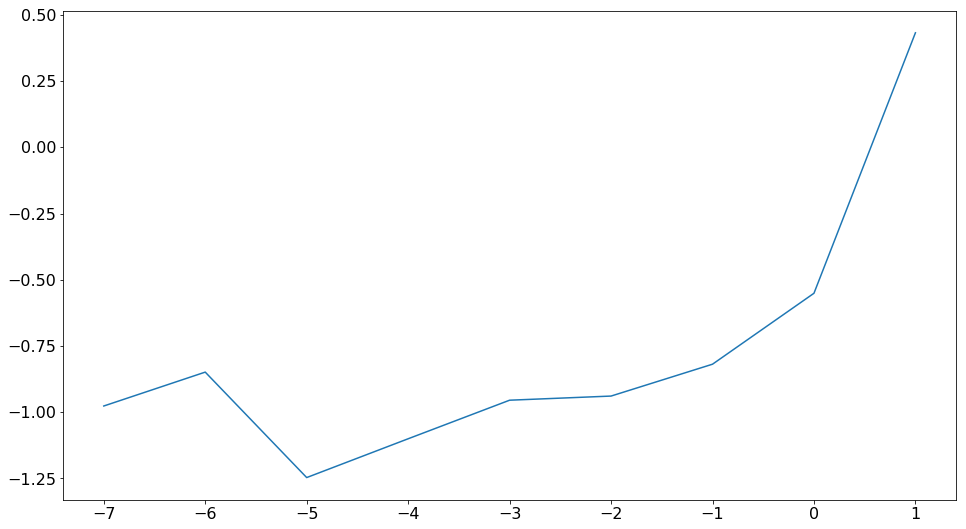

In [426]:
plt.plot(np.log10(errors),res)

0.46336435000926174